# Check data in detail

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

from data_manager import DataManager
import transport_signal_processing as tsp

### Input parameters

In [2]:
# Choose database path for data to look at
path = "3MGdmClpH4_PNA_400uM_K238A_25C_110mV"

# if selection from B0 should be applied: selected = True
want_sel = True

### Load data

In [3]:
# define session directory
session_name = path.replace('*','+').replace('/','-')
session_path = os.path.join("results/", session_name)
if not os.path.exists(session_path):
    os.makedirs(session_path)
print("Results save path: {}".format(session_path))

# setup database connector
sigman = DataManager('database', safe=False)

# load informations
mdf = pd.DataFrame(sigman.load_info(path, 'm*'))
sdf = pd.DataFrame(sigman.load_info(path, 's*')).dropna().sort_values("N_cores", ascending=False)

# get all session segments info
sinfo_l = [dict(r) for _, r in sdf.iterrows()]

# load data
selected, _ = tsp.utils.load_segments_data(sigman, sinfo_l, "selected")
stats, ids = tsp.utils.load_segments_data(sigman, sinfo_l, "stats")
stats = np.array(stats)

# pack data
data = {
    "id": sdf.iloc[ids]["date"].values+'_'+ sdf.iloc[ids]["id"].values+"_CH"+sdf.iloc[ids]["channel"],
    "sid": sdf.iloc[ids]["sid"].values,
    "voltage": sdf.iloc[ids]["voltage"].values,
    "dwell time [s]": stats[:,0],
    "mean current [pA]": stats[:,1],
    "standard deviation [pA]": stats[:,2],
    "skewness": stats[:,3],
    "kurtosis": stats[:,4],
    "mean open pore current [pA]": sdf.iloc[ids]["mI_open"].values,
    "standard deviation open pore current [pA]": sdf.iloc[ids]["sI_open"].values,
    "rel standard deviation event/open pore [pA]": stats[:,2] / sdf.iloc[ids]["sI_open"].values,
    "selected": np.array(selected).astype(int),
}

# create dataframe
df = pd.DataFrame(data)

#select data
if want_sel == True:
    df_good = df.loc[df['selected'] > 0]
else:
    df_good = df

# debug display
df

Results save path: results/3MGdmClpH4_PNA_400uM_K238A_25C_110mV


,id,sid,voltage,dwell time [s],mean current [pA],standard deviation [pA],skewness,kurtosis,mean open pore current [pA],standard deviation open pore current [pA],rel standard deviation event/open pore [pA],selected
486,24082023_8_CH002,3,110,0.00029,-6.707093,24.753977,-0.899824,-0.712733,176.253073,6.169144,4.012547,0
486,24082023_8_CH002,3,110,0.01865,0.312923,9.041589,-0.764660,7.205618,176.253073,6.169144,1.465615,0
486,24082023_8_CH002,3,110,0.00088,124.193805,5.145202,0.507445,-0.255631,176.253073,6.169144,0.834022,0
486,24082023_8_CH002,3,110,0.00089,117.988915,9.075821,-1.679932,5.158595,176.253073,6.169144,1.471164,0
486,24082023_8_CH002,3,110,0.00027,18.923992,16.210187,-0.202797,-1.437923,176.253073,6.169144,2.627623,0
...,...,...,...,...,...,...,...,...,...,...,...,...
376,23082023_10-1_CH003,100,110,0.14898,94.938152,8.949287,0.028467,1.940897,254.572419,7.860590,1.138501,1
376,23082023_10-1_CH003,100,110,0.00019,104.027139,1.238070,0.300613,-1.118360,254.572419,7.860590,0.157503,1
387,23082023_10-1_CH003,111,110,0.01097,81.598103,7.846174,0.168940,1.726661,129.698495,8.112622,0.967156,0
387,23082023_10-1_CH003,111,110,0.00285,77.301273,6.822875,-0.180127,1.894188,129.698495,8.112622,0.841020,1


### print out each recording color coded with relative event noise 

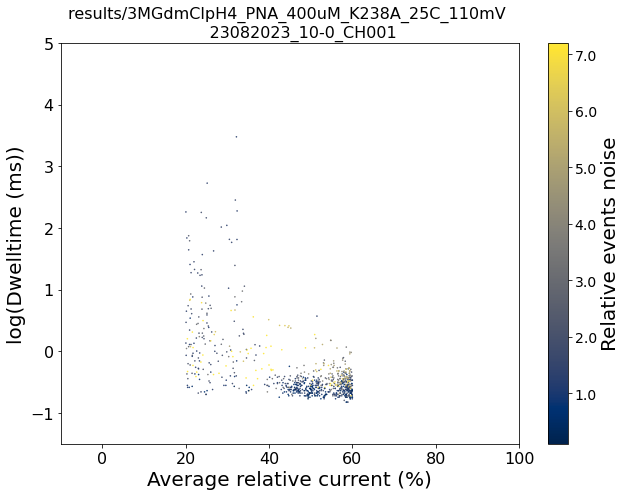

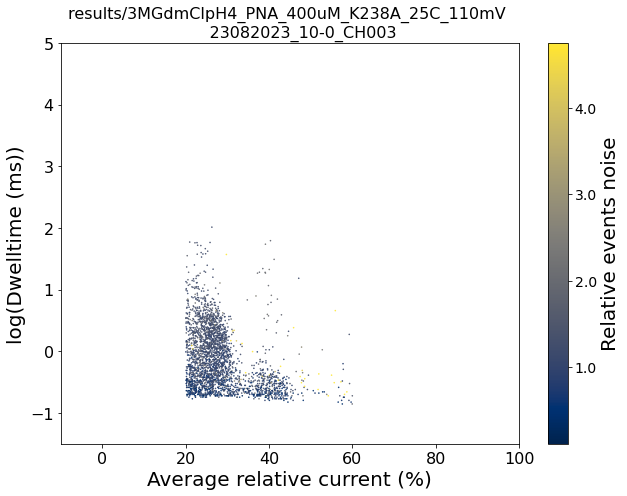

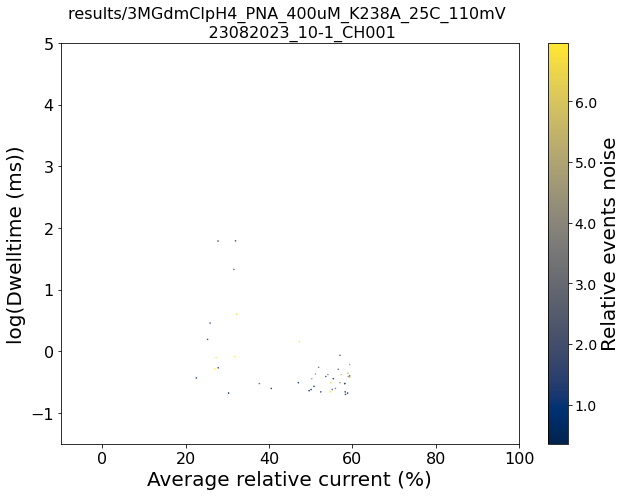

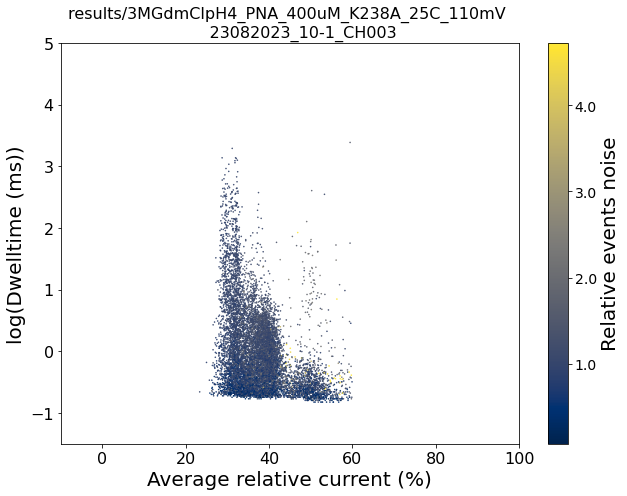

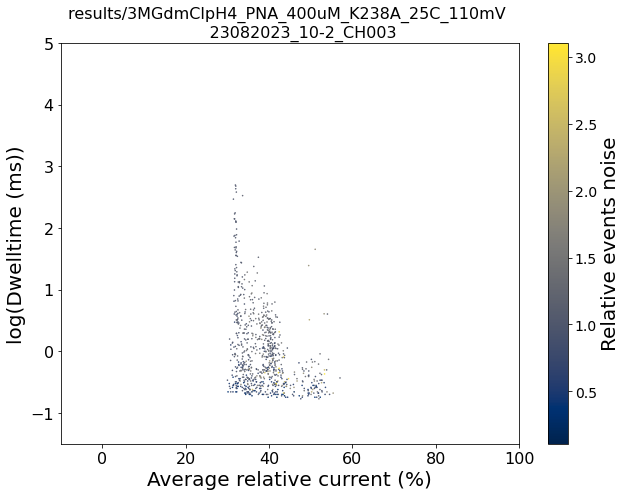

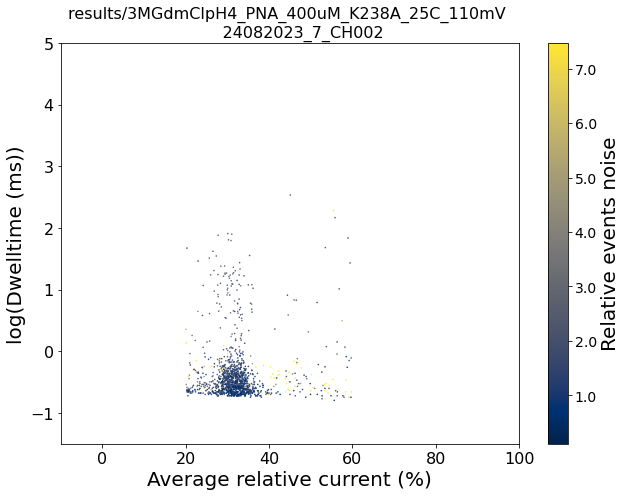

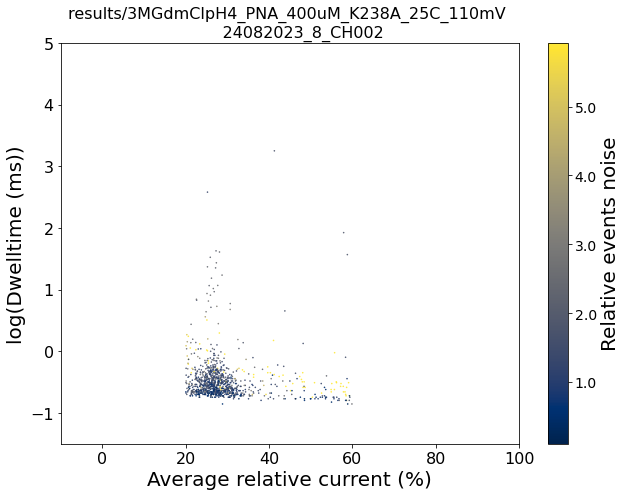

In [6]:
fsz = 20
table = np.array(df_good)
id = table[:,0]

for i in np.unique(id):
    ids = np.where(id == i)[0]
    kurtosis = stats[ids,4]
    rel_sig_ev = table[ids,10]
    avg_cur = table[ids,4]/table[ids,8]
    dwt = df_good['dwell time [s]'].values
    log_dwt = np.log10(dwt*1000)
    log_dwt = log_dwt[ids]

    cmap = plt.get_cmap('cividis')
    min_cmap = min(rel_sig_ev)  # Bottom of colorbar is variable sum1
    max_cmap = max(rel_sig_ev) - 0.5*(max(rel_sig_ev)-min(rel_sig_ev))  # Top of colorbar is variable sum2
    #max_cmap = max(rel_sig_ev)

    plt.figure(figsize = (9,7))
    plt.scatter(avg_cur*100, log_dwt, c = rel_sig_ev, vmin=min_cmap, vmax=max_cmap, cmap=cmap, s=0.3)
    plt.xlim(-10,100)
    plt.ylim(-1.5,5)
    #plt.legend('colored by rel standard deviation')
    plt.xlabel('Average relative current (%)', fontsize = fsz)
    plt.ylabel('log(Dwelltime (ms))', fontsize = fsz)
    plt.yticks(fontsize = fsz*0.8)
    plt.xticks(fontsize = fsz*0.8)
    plt.title('''{} 
     {}'''.format(session_path, i), fontsize = 0.8*fsz)
    
    sbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min_cmap, max_cmap)), 
                     orientation='vertical', format='%.1f', label="rel sig ev")
    sbar.set_label(label="Relative events noise", fontsize = fsz)
    sbar.ax.tick_params(labelsize=fsz*0.7)
    plt.tight_layout()
    #plt.savefig('graphs/{}_scatterplot.png'.format(i), dpi=300)
    plt.show()

## print scatter plots based on more data parameters

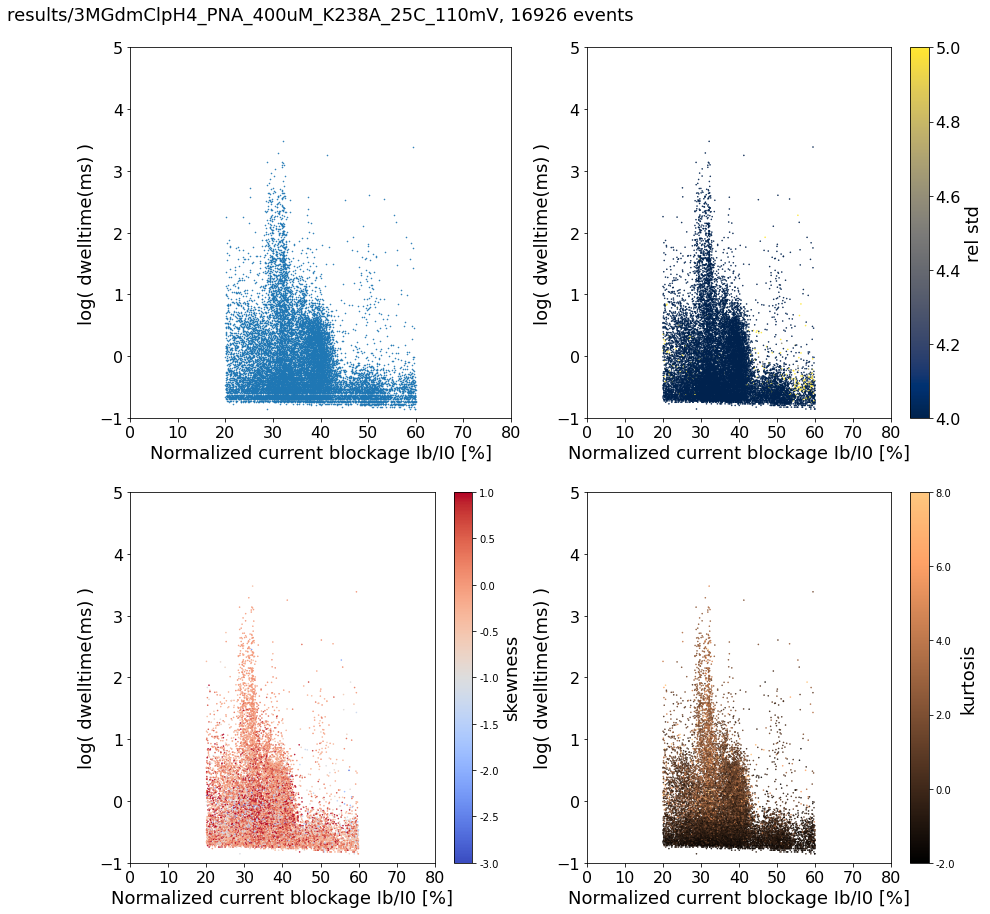

In [5]:
fsz = 18 
table = np.array(df_good)
kurtosis = table[:,7]
skewness = table[:,6]
rel_sig_ev = table[:,10]
avg_cur_all = 100 * table[:,4]/table[:,8]
dwt = df_good['dwell time [s]'].values
log_dwt = np.log10(dwt*1000)

cmap_sig = plt.get_cmap('cividis')
min_cmap_sig = min(rel_sig_ev)  # Bottom of colorbar is variable sum1
max_cmap_sig = max(rel_sig_ev) - 0.5*(max(rel_sig_ev)-min(rel_sig_ev))   # Top of colorbar is variable sum2
min_cmap_sig = 4
max_cmap_sig = 5
ylim = (-1,5)



cmap_kurt = plt.get_cmap('copper')
min_cmap_kurt = -2  # Bottom of colorbar is variable sum1
max_cmap_kurt = 8   # Top of colorbar is variable sum2

cmap_skew = plt.get_cmap('coolwarm')
min_cmap_skew = -3  # Bottom of colorbar is variable sum1
max_cmap_skew = 1   # Top of colorbar is variable sum2

    
plt.figure(figsize = (15,15))
gs = GridSpec(nrows=2, ncols=2)

plt.subplot(gs[0,0])
plt.scatter(avg_cur_all, log_dwt, s=0.3)
plt.xlim(0,80)
plt.ylim(ylim)
plt.xlabel('Normalized current blockage Ib/I0 [%]', fontsize = fsz)
plt.title('''{}, {} events
'''.format(session_path, len(log_dwt)), fontsize = fsz)
plt.ylabel('log( dwelltime(ms) )', fontsize = fsz)
plt.xticks(fontsize = fsz-2)
plt.yticks(fontsize = fsz-2)
    
plt.subplot(gs[0,1])
plt.scatter(avg_cur_all, log_dwt, c = rel_sig_ev,vmin=min_cmap_sig, vmax=max_cmap_sig, cmap=cmap_sig, s=0.3)
plt.xlim(0,80)
plt.ylim(ylim)
#plt.xlabel('rel current blockage [%]', fontsize = fsz)
plt.xlabel('Normalized current blockage Ib/I0 [%]', fontsize = fsz)
plt.ylabel('log( dwelltime(ms) )', fontsize = fsz)
plt.xticks(fontsize = fsz-2)
plt.yticks(fontsize = fsz-2)
#plt.title('''colored: rel standard deviation''', fontsize = fsz)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap_sig, norm=plt.Normalize(min_cmap_sig, max_cmap_sig)), 
                 orientation='vertical', format='%.1f')
cbar.ax.tick_params(labelsize=fsz-2)
cbar.set_label(label="rel std", fontsize = fsz)


plt.subplot(gs[1,1])
plt.scatter(avg_cur_all, log_dwt, c = kurtosis, vmin=min_cmap_kurt, vmax=max_cmap_kurt, cmap=cmap_kurt, s=0.3)
plt.xlim(0,80)
plt.ylim(ylim)
plt.xlabel('Normalized current blockage Ib/I0 [%]', fontsize = fsz)
plt.ylabel('log( dwelltime(ms) )', fontsize = fsz)
plt.xticks(fontsize = fsz-2)
plt.yticks(fontsize = fsz-2)
#plt.title('')
kbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap_kurt, norm=plt.Normalize(min_cmap_kurt, max_cmap_kurt)), 
                 orientation='vertical', format='%.1f')
kbar.set_label(label="kurtosis", fontsize = fsz)


plt.subplot(gs[1,0])
plt.scatter(avg_cur_all, log_dwt, c = skewness, cmap=cmap_skew, vmin = min_cmap_skew, vmax = max_cmap_skew, s=0.3)
plt.xlim(0,80)
plt.ylim(ylim)
plt.xlabel('Normalized current blockage Ib/I0 [%]', fontsize = fsz)
plt.ylabel('log( dwelltime(ms) )', fontsize = fsz)
plt.xticks(fontsize = fsz-2)
plt.yticks(fontsize = fsz-2)

sbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap_skew, norm=plt.Normalize(min_cmap_skew, max_cmap_skew)), 
                 orientation='vertical', format='%.1f', label="skewness")
sbar.set_label(label="skewness", fontsize = fsz)

#plt.savefig('graphs/{}_scatterplot.png'.format(session_path), dpi=300)
plt.show()